In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [2]:
PICKLE_PATH = '../augmented_datasets/pickles/final_data/hopkins_death_narrow_0605.pkl'
OUTLIER_QUARTILES = (0.02, 0.98) # Min, max quartiles

In [3]:
def remove_outlier(df, range_, columns):
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data.dropna()

def calc_corrs_scatter(df, outliers=(0,0), gdp_thr=0, urb_thr=0, only_us=False,\
                       show_names=False, show_states=False, temp_outliers=(0,0)):

    targets = ['proxy', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']

    for target in targets:
        print('Interval temp vs {0} correlations'.format(target))
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, [target])
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        confs1.dropna(inplace=True)
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]       
        gf = confs1[target].loc[:,'data'].values.tolist()
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        corr_p1 = stats.pearsonr(gf, avg_int_tmp)
        corr_s1 = stats.spearmanr(gf, avg_int_tmp)

        print('n={0}'.format(len(gf)))
        print('Pearson: {0}\tOne sided p_value: {1}'.format(corr_p1[0], corr_p1[1] / 2))
        print('Spearman: {0}\tOne sided p_value: {1}\n'.format(corr_s1[0], corr_s1[1] / 2))

    if outliers == (0,0):
        confs1 = df.copy()
    else:
        confs1 = remove_outlier(df, outliers, ['proxy'])
    if temp_outliers != (0,0):
        confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
    if only_us:
        confs1 = confs1[confs1['Country_Region'] == 'US']
    confs1 = confs1[confs1['GDP'] > gdp_thr]
    confs1 = confs1[confs1['Urbanization'] > urb_thr]       
    
    confs1.dropna(inplace=True)
    
    proxy = confs1['proxy'].loc[:,'data'].values.tolist()
    avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

    fig, axes = plt.subplots(figsize=(15, 7))
    _ = axes.scatter(avg_int_tmp1, proxy)
    n = len(proxy)

    _ = axes.set_xlabel('avg interval temp')
    _ = axes.set_ylabel('proxy')
    _ = axes.set_title('n={0}'.format(n))

    if show_names:
        countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(countries1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], proxy[i]))

    if show_states and not show_names:
        states1 = confs1['Province_State'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(states1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], proxy[i]))
            
def manual_WRS(gf_qx, df, temp_range):

    colds = df[df['avg_interval_tmp'] <= temp_range[0]]\
        [[gf_qx]]

    hots = df[df['avg_interval_tmp'] >= temp_range[1]]\
        [[gf_qx]]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    size = {
           'colds': b,
           'hots': len(hots.columns)
           }
    
    return {'expected': expected_cold_sum, 
            'attained': c_sum, 
            'p': p_value, 
            'sigma': sigma, 
            'size': size}

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print(
         '# colds samples: {0}\n# of hots samples: {1}\n'
         'Expected mean for cold countries rank sum: {2}\n'
         'Attained mean for cold countries rank sum: {3}\n'
         'Sigma: {4}\n'
         '(Attained mean) - (Expected mean) = {5}\n'
         'p-value for this result is: {6}'
         .format(qx_results[4]['colds'], qx_results[4]['hots'], qx_results[0],\
                 qx_results[1], difference, qx_results[3], qx_results[2]))

def builtin_WRS(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}

def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
#     print('--------------------------------------------------')


def builtin_ttest(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('# colds: {0}\n# of hots: {1}'.format(qx_results[2]['colds'], qx_results[2]['hots']))
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
    print('--------------------------------------------------')

def calc_wrs_ttest(df, temp_range):
    Q1_manual = manual_WRS('GF_Q1', df, temp_range)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', df, temp_range)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', df, temp_range)
    print_builtin_ttest('Q1', Q1_ttest)
    
#     Q3_manual = manual_WRS('GF_Q3', df)
#     print_manual_WRS('Q3', Q3_manual)

#     Q3_builtin = builtin_WRS('GF_Q3', df)
#     print_builtin_WRS('Q3', Q3_builtin)

#     Q3_ttest = builtin_ttest('GF_Q3', df)
#     print_builtin_ttest('Q3', Q3_ttest)     

In [4]:
hopkins_death = pd.read_pickle(PICKLE_PATH)
# these are unique to US and will cause problems here
hopkins_death.drop(columns=['State Population', 'Total Tests', 'Tests \ Pop'], inplace=True)
hopkins_death.dropna(inplace=True)

In [8]:
hopkins_death.insert(2, 'proxy', np.nan)

In [9]:
hopkins_death['proxy'] = (1000 * hopkins_death['GF_Q3'] * hopkins_death['GDP']) / \
                         ((hopkins_death['Median Age']**2) * hopkins_death['Gini Index'] * hopkins_death['Democracy'])

In [11]:
PLAIN = {'df': hopkins_death,
        'show_names': True
        }

OUTLIERS = {
            'df': hopkins_death,
            'outliers': (0.02,0.98)
            }

GDP_URB1 = {
            'df': hopkins_death,
            'outliers': (0.02,0.98),
            'gdp_thr': 30000,
            'urb_thr': 80
            }

GDP_URB2 = {
            'df': hopkins_death,
            'outliers': (0.02,0.98),
            'gdp_thr': 36000,
            'urb_thr': 84
            }

GDP_URB3 = {
            'df': hopkins_death,
            'outliers': (0.02,0.98),
            'gdp_thr': 43000,
            'urb_thr': 88
            }

US_ONLY = {
            'df': hopkins_death,
            'outliers': (0.02,0.98),
            'only_us': True,
            'show_states': True
            }

TEMP_OUTLIERS = {
            'df': hopkins_death,
            'outliers': (0.02,0.98),
            'temp_outliers': (0.1, 0.9)
            }

In [13]:
hopkins_death.describe()
us_states = len(hopkins_death[hopkins_death['Country_Region'] == 'US'])
print('Of which {0} are US locations'.format(us_states))

,proxy,GDP,Urbanization,Median Age,Democracy,Gini Index,avg_mobility,Tests per 1M,avg_interval_RH,avg_interval_tmp,...,4/27/2020,4/28/2020,4/29/2020,4/30/2020,5/1/2020,5/2/2020,5/3/2020,5/4/2020,5/5/2020,5/6/2020
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,...,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,7.246540,53947.147765,74.559621,37.691781,7.804164,40.885564,17.300040,34399.716184,65.984910,14.171793,...,184.106849,189.756164,195.913242,200.912329,205.671233,210.305023,213.524201,217.036530,222.123288,227.893151
std,9.059177,17231.170175,13.440880,3.638262,0.835419,2.769070,3.951080,10444.306072,9.751206,6.080029,...,1618.754090,1650.857549,1685.759551,1710.284510,1734.145201,1763.132753,1780.604162,1797.703028,1821.769793,1850.538395
min,0.000000,413.980305,16.425000,15.100000,1.930000,24.200000,3.218182,147.000000,8.648649,-4.879310,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,48318.000000,66.300000,36.600000,7.960000,41.400000,14.845000,35539.000000,62.629121,9.636007,...,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,2.024052,55172.000000,75.100000,38.100000,7.960000,41.400000,16.571429,35539.000000,67.275862,13.640909,...,7.000000,8.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,11.000000,11.000000
75%,13.623655,61594.000000,84.700000,39.300000,7.960000,41.400000,18.794471,35539.000000,71.835586,18.077820,...,24.000000,24.000000,25.000000,28.000000,28.000000,29.000000,29.000000,29.000000,31.500000,31.500000
max,67.914135,200277.000000,100.000000,48.200001,9.870000,63.000000,39.282051,166416.000000,94.200000,34.948649,...,26977.000000,27359.000000,27682.000000,27967.000000,28236.000000,28710.000000,28884.000000,29079.000000,29427.000000,30076.000000


Of which 969 are US locations


###### CORRELATIONS AND SCATTER PLOTS PER GF
Even after screening for place where confirmed cases > 20 we still get episodes where GF_Q1 or GF_Q3 equals zero
For this reason we remove the outliers and compute correlations for each GF seperatly

GDP and URB refference :
* MEAN   - 22914, 67
* USA    - 62794, 82
* ISRAEL - 41715, 92
* FRANCE - 41463, 80

AVG_INT_TEMP refference :
* MEAN   - 12.75
* Q1     - 6.83
* Q3.    - 17.91

###### No filters - all data

Interval temp vs proxy correlations
n=1095
Pearson: -0.10654682982775994	One sided p_value: 0.0002064107267095987
Spearman: -0.12959459341665086	One sided p_value: 8.476905233428025e-06

Interval temp vs GF_Q1 correlations
n=1095
Pearson: -0.00703110351825865	One sided p_value: 0.4081129509371829
Spearman: -0.06512906056928137	One sided p_value: 0.01558097861404386

Interval temp vs GF_Q2 correlations
n=1095
Pearson: -0.03795100362326652	One sided p_value: 0.10476730227681158
Spearman: -0.08779779005218874	One sided p_value: 0.001821093971211982

Interval temp vs GF_Q3 correlations
n=1095
Pearson: -0.03866875816729283	One sided p_value: 0.10051963294835953
Spearman: -0.08921815238066702	One sided p_value: 0.0015642534697677647

Interval temp vs first_7 correlations
n=1095
Pearson: 0.0278897868256578	One sided p_value: 0.17825902446884717
Spearman: -0.009015235554714021	One sided p_value: 0.38285671785910774



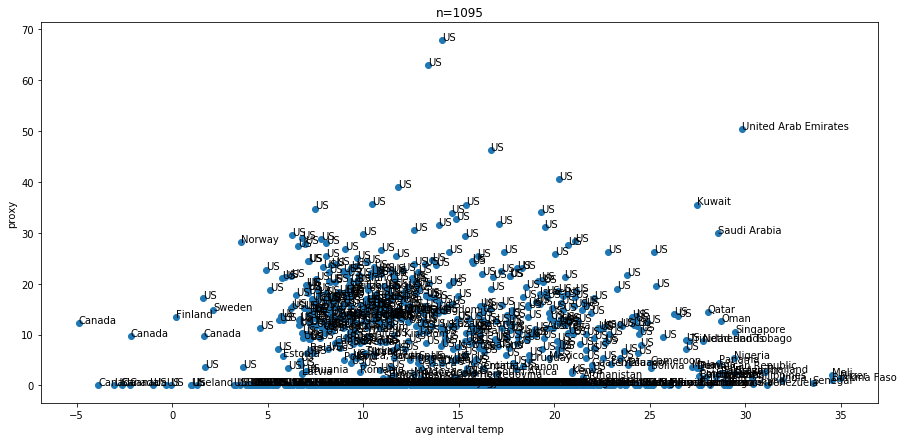

In [14]:
calc_corrs_scatter(**PLAIN)

###### No outliers - 0.02, 0.98

Interval temp vs proxy correlations
n=543
Pearson: -0.3130815127732032	One sided p_value: 4.093926827804194e-14
Spearman: -0.27305988777356377	One sided p_value: 4.8464763076701385e-11

Interval temp vs GF_Q1 correlations
n=134
Pearson: -0.071066371304355	One sided p_value: 0.20725636669970615
Spearman: -0.02637596947686031	One sided p_value: 0.3811293341349416

Interval temp vs GF_Q2 correlations
n=262
Pearson: -0.05987167550632395	One sided p_value: 0.1671872176866525
Spearman: -0.027643765820650746	One sided p_value: 0.3280156898039217

Interval temp vs GF_Q3 correlations
n=541
Pearson: -0.11450058497623264	One sided p_value: 0.0038399466758212374
Spearman: -0.1277928621206058	One sided p_value: 0.001451964633346093

Interval temp vs first_7 correlations
n=656
Pearson: 0.045077035447559255	One sided p_value: 0.12447168576649296
Spearman: 0.023601177087607762	One sided p_value: 0.273115897847921



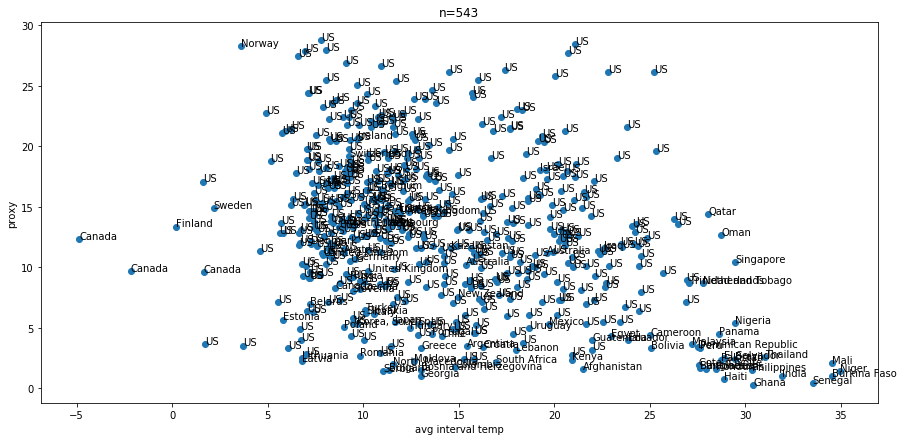

In [50]:
calc_corrs_scatter(**OUTLIERS, show_names=True)

###### GDP 30K, URB 80

Interval temp vs proxy correlations
n=206
Pearson: -0.25689359326587136	One sided p_value: 9.672072560989652e-05
Spearman: -0.27962467693232246	One sided p_value: 2.3461938915867978e-05

Interval temp vs GF_Q1 correlations
n=60
Pearson: -0.21603057405604947	One sided p_value: 0.04867847297592949
Spearman: -0.08613503751041958	One sided p_value: 0.2564329416626252

Interval temp vs GF_Q2 correlations
n=127
Pearson: -0.033766418286478535	One sided p_value: 0.35313388651505695
Spearman: -0.009042987145602248	One sided p_value: 0.45981344063198115

Interval temp vs GF_Q3 correlations
n=211
Pearson: -0.09719082310914227	One sided p_value: 0.07975458409439386
Spearman: -0.11065181235372508	One sided p_value: 0.05450180833139501

Interval temp vs first_7 correlations
n=250
Pearson: 0.0013804638830368686	One sided p_value: 0.4913365828275636
Spearman: -0.011970735061185699	One sided p_value: 0.4253081482171669



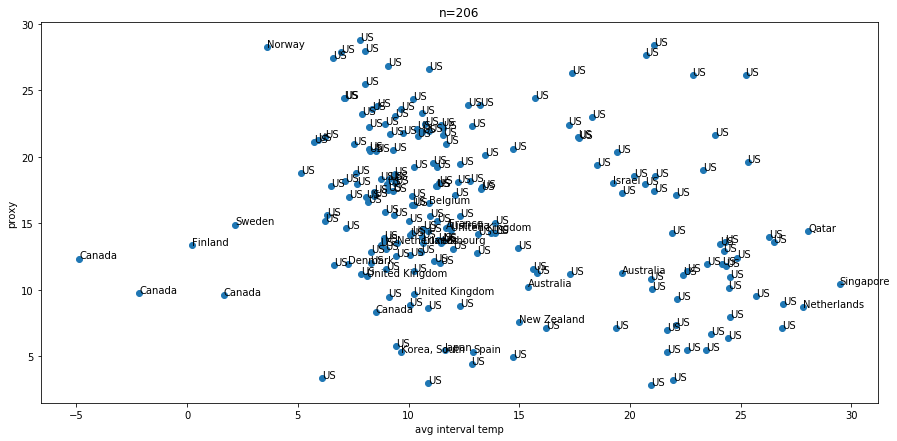

In [51]:
calc_corrs_scatter(**GDP_URB1, show_names=True)

###### GDP 36K, URB 84

Interval temp vs proxy correlations
n=189
Pearson: -0.3178603868395093	One sided p_value: 4.155564095623996e-06
Spearman: -0.32796262276970267	One sided p_value: 2.0436537715581724e-06

Interval temp vs GF_Q1 correlations
n=52
Pearson: -0.195975248726508	One sided p_value: 0.08190246635135959
Spearman: -0.04328523862375139	One sided p_value: 0.3803013426952816

Interval temp vs GF_Q2 correlations
n=113
Pearson: -0.0023352841401050556	One sided p_value: 0.4902075777410619
Spearman: 0.03843482673253534	One sided p_value: 0.343042205916098

Interval temp vs GF_Q3 correlations
n=193
Pearson: -0.12144377536895942	One sided p_value: 0.04624333108902726
Spearman: -0.1241080159610471	One sided p_value: 0.04275095232153215

Interval temp vs first_7 correlations
n=223
Pearson: -0.00791847134403801	One sided p_value: 0.4531981282783696
Spearman: -0.014896029514816195	One sided p_value: 0.41246550731719794



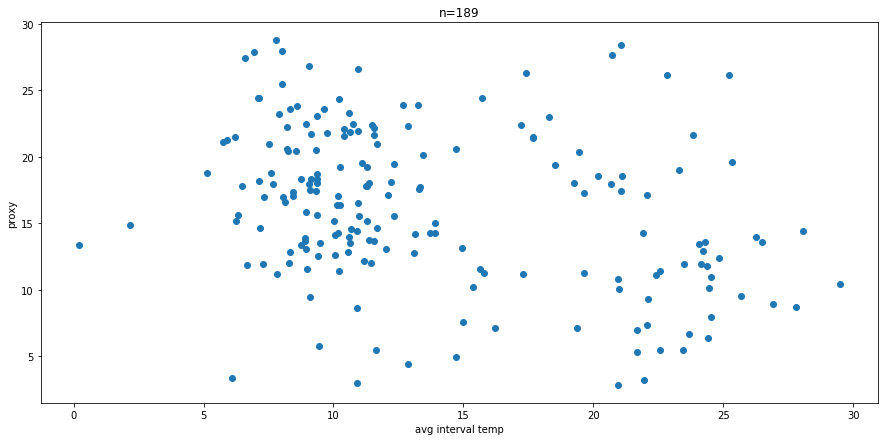

In [52]:
calc_corrs_scatter(**GDP_URB2)

###### GDP 43K, URB 88

Interval temp vs proxy correlations
n=99
Pearson: -0.509155433434246	One sided p_value: 3.6913229277173305e-08
Spearman: -0.5455506836881301	One sided p_value: 2.6202519681650605e-09

Interval temp vs GF_Q1 correlations
n=30
Pearson: -0.3982882985227572	One sided p_value: 0.014631737569158684
Spearman: -0.23203559510567295	One sided p_value: 0.10863265832246281

Interval temp vs GF_Q2 correlations
n=63
Pearson: -0.07327113967347951	One sided p_value: 0.28410365481365096
Spearman: -0.05234986324499725	One sided p_value: 0.34183027106489294

Interval temp vs GF_Q3 correlations
n=100
Pearson: -0.18612125705631055	One sided p_value: 0.031866148589239744
Spearman: -0.19594158743456314	One sided p_value: 0.02536455203424356

Interval temp vs first_7 correlations
n=113
Pearson: -0.04378771999130135	One sided p_value: 0.32257314679090054
Spearman: -0.10954698958187936	One sided p_value: 0.12403850550968304



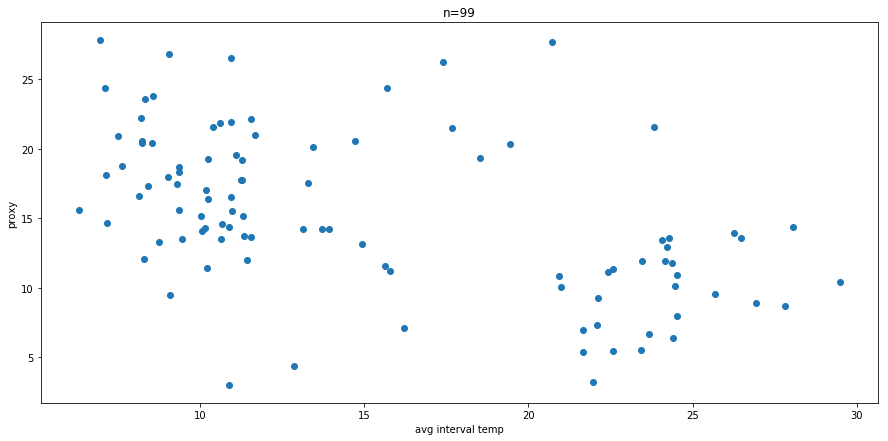

In [53]:
calc_corrs_scatter(**GDP_URB3)

###### US only

Interval temp vs proxy correlations
n=452
Pearson: -0.17755009066872582	One sided p_value: 7.396940803560069e-05
Spearman: -0.19409054455815222	One sided p_value: 1.6295104575782413e-05

Interval temp vs GF_Q1 correlations
n=86
Pearson: -0.18019487271169396	One sided p_value: 0.04843450628587171
Spearman: -0.10316247299809088	One sided p_value: 0.17227451689247258

Interval temp vs GF_Q2 correlations
n=202
Pearson: -0.09056908276912737	One sided p_value: 0.09994301162793211
Spearman: -0.05923909959620273	One sided p_value: 0.20116797941448594

Interval temp vs GF_Q3 correlations
n=447
Pearson: -0.0843878497972717	One sided p_value: 0.037346559540194675
Spearman: -0.11096989668923447	One sided p_value: 0.009466431640528425

Interval temp vs first_7 correlations
n=550
Pearson: 0.07009995165678214	One sided p_value: 0.05026702311766936
Spearman: 0.04812128455953373	One sided p_value: 0.1299496101064293



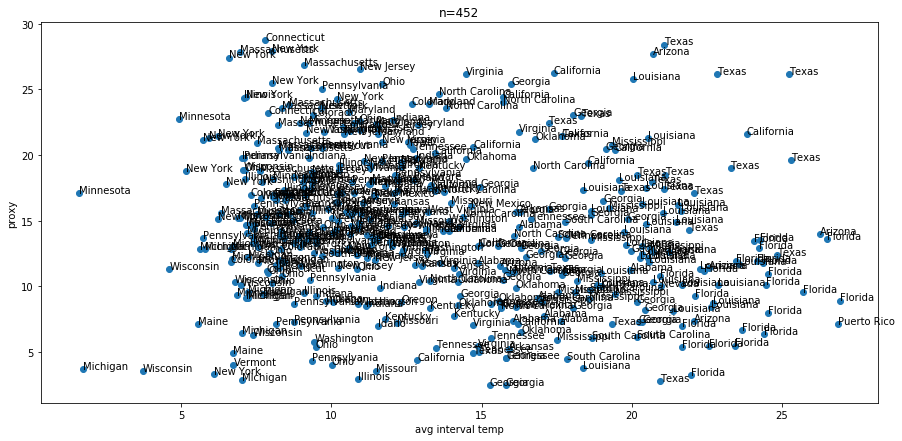

In [54]:
calc_corrs_scatter(**US_ONLY)

###### TEMP OUTLIERS 0.1, 0.9

Interval temp vs proxy correlations
n=433
Pearson: -0.20313453251893585	One sided p_value: 1.0256881009107893e-05
Spearman: -0.22109529660735222	One sided p_value: 1.7003500525305773e-06

Interval temp vs GF_Q1 correlations
n=106
Pearson: -0.09973648857641258	One sided p_value: 0.15452590079455342
Spearman: -0.01660087614340968	One sided p_value: 0.43293703507956366

Interval temp vs GF_Q2 correlations
n=208
Pearson: -0.0651859220604518	One sided p_value: 0.17477702837248477
Spearman: -0.012203420122194589	One sided p_value: 0.43056098837812706

Interval temp vs GF_Q3 correlations
n=431
Pearson: -0.17080479357611525	One sided p_value: 0.0001840830204609458
Spearman: -0.1890310955639398	One sided p_value: 3.929716730045595e-05

Interval temp vs first_7 correlations
n=524
Pearson: 0.0005874536775284298	One sided p_value: 0.4946482236027414
Spearman: -0.024875882583031184	One sided p_value: 0.284962137106326



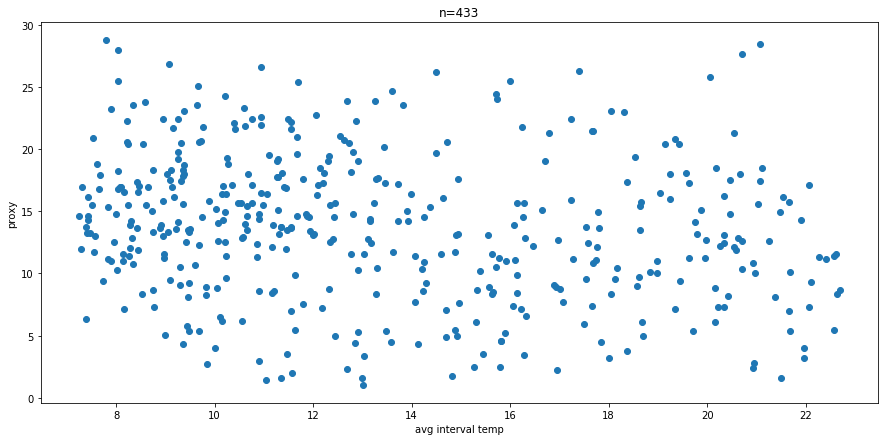

In [55]:
calc_corrs_scatter(**TEMP_OUTLIERS)

###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q3 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [15]:
col = ['GF_Q1']
range_=(0.02,0.98)
gdp_th = 43000
urban_th = 88
# temp_range = (hopkins_confirmed['avg_interval_tmp'].quantile(0.1),\
#          hopkins_confirmed['avg_interval_tmp'].quantile(0.9))
temp_range = (13, 13.1)

hopkins_gdp_urban_th = hopkins_confirmed[hopkins_confirmed['GDP'] >= gdp_th].copy()
hopkins_gdp_urban_th = hopkins_gdp_urban_th[hopkins_gdp_urban_th['Urbanization'] >= urban_th].copy()
hopkins_without_outliers = remove_outlier(hopkins_confirmed, range_, [col])
hopkins_without_outliers.dropna(inplace=True)
len(hopkins_without_outliers)

923

In [16]:
arrays = [['With Outliers', 'With Outliers', 'No Outliers', 'No Outliers'],\

          ['No TH','GDP and URBAN TH', \
           'No TH','GDP and URBAN TH']]

idx = pd.MultiIndex.from_arrays(arrays, names=('Outliers', 'Thresholds'))

stats_rslt = pd.DataFrame(index=idx)

arrays_2 = [['Info on Distribution', 'Info on Distribution', 'Info on Distribution', 'WRS - manual', 'WRS - manual', 'WRS - builtin', 'WRS - builtin', 'TTest - builtin', 'TTest - builtin'], \
            ['Expected Mean', 'Attained Mean', 'Sigma', '(Expected - Attained)', 'p value', 't statistic', 'p value', 't statistic', 'p value']]
stats_rslt = stats_rslt.reindex(arrays_2, axis = 1)

stats_rslt

Info on Distribution                      \
                                      Expected Mean Attained Mean Sigma   
Outliers      Thresholds                                                  
With Outliers No TH                             NaN           NaN   NaN   
              GDP and URBAN TH                  NaN           NaN   NaN   
No Outliers   No TH                             NaN           NaN   NaN   
              GDP and URBAN TH                  NaN           NaN   NaN   

                                        WRS - manual         WRS - builtin  \
                               (Expected - Attained) p value   t statistic   
Outliers      Thresholds                                                     
With Outliers No TH                              NaN     NaN           NaN   
              GDP and URBAN TH                   NaN     NaN           NaN   
No Outliers   No TH                              NaN     NaN           NaN   
              GDP and URBAN TH                   NaN     NaN           NaN   

                                       TTest - builtin          
                               p value     t statistic p value  
Outliers      Thresholds                                        
With Outliers No TH                NaN             NaN     NaN  
              GDP and URBAN TH     NaN             NaN     NaN  
No Outliers   No TH                NaN             NaN     NaN  
              GDP and URBAN TH     NaN             NaN     NaN

In [17]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])


NO_OUT = 'No Outliers'
WITH_OUT = 'With Outliers'
NO_TH = 'No TH'
WITH_TH = 'GDP and URBAN TH'


df_dict = {
    'no_outliers_no_th': {
        'df': hopkins_confirmed,
        'out': NO_OUT,
        'th': NO_TH
    },
    'no_outliers_urban_gdp_th': {
        'df': hopkins_gdp_urban_th,
        'out': NO_OUT,
        'th': WITH_TH
    },
    'with_outliers_no_th': {
        'df': hopkins_without_outliers,
        'out': WITH_OUT,
        'th': NO_TH
    },
    'with_outliers_urban_gdp_th':  {
        'df': hopkins_gdp_urban_th_no_outliers,
        'out': WITH_OUT,
        'th': WITH_TH
    }
}

for key in df_dict:
    df = df_dict[key]['df']
    out = df_dict[key]['out']
    th = df_dict[key]['th']

    result = manual_WRS('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('Info on Distribution', 'Expected Mean')] = result['expected']
    stats_rslt.loc[(out, th),('Info on Distribution', 'Attained Mean')] = float(result['attained'])
    stats_rslt.loc[(out, th),('Info on Distribution', 'Sigma')] = int(result['sigma'])
    stats_rslt.loc[(out, th),('WRS - manual', '(Expected - Attained)')] = float(result['attained']) - float(result['expected'])
    stats_rslt.loc[(out, th),('WRS - manual', 'p value')] = float(result['p'])
    
    result = builtin_WRS('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('WRS - builtin', 't statistic')] = float(result['t'])
    stats_rslt.loc[(out, th),('WRS - builtin', 'p value')] = float(result['p'])
    
    result = builtin_ttest('GF_Q1', df, temp_range)
    stats_rslt.loc[(out, th),('TTest - builtin', 't statistic')] = float(result['t'])
    stats_rslt.loc[(out, th),('TTest - builtin', 'p value')] = float(result['p'])

stats_rslt

Info on Distribution                         \
                                      Expected Mean Attained Mean    Sigma   
Outliers      Thresholds                                                     
With Outliers No TH                        210910.0      230998.5   4003.0   
              GDP and URBAN TH               7200.0        8378.5    287.0   
No Outliers   No TH                        788970.0      822178.0  11188.0   
              GDP and URBAN TH              15080.0       16350.5    503.0   

                                        WRS - manual                \
                               (Expected - Attained)       p value   
Outliers      Thresholds                                             
With Outliers No TH                          20088.5  2.616663e-07   
              GDP and URBAN TH                1178.5  2.105649e-05   
No Outliers   No TH                          33208.0  1.498531e-03   
              GDP and URBAN TH                1270.5  5.839895e-03   

                               WRS - builtin               TTest - builtin  \
                                 t statistic       p value     t statistic   
Outliers      Thresholds                                                     
With Outliers No TH                 5.017555  5.233327e-07        4.409865   
              GDP and URBAN TH      4.095571  4.211298e-05        3.859823   
No Outliers   No TH                 2.968039  2.997061e-03        2.353155   
              GDP and URBAN TH      2.521674  1.167979e-02        2.119297   

                                          
                                 p value  
Outliers      Thresholds                  
With Outliers No TH             0.000012  
              GDP and URBAN TH  0.000165  
No Outliers   No TH             0.018721  
              GDP and URBAN TH  0.035142

In [18]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_without_outliers, temp_range)




--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

In [19]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])

print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th_no_outliers, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

Text(0.5,0,'Average Interval Temperature')

Text(0,0.5,'Growth Factor')

NameError: name 'n' is not defined

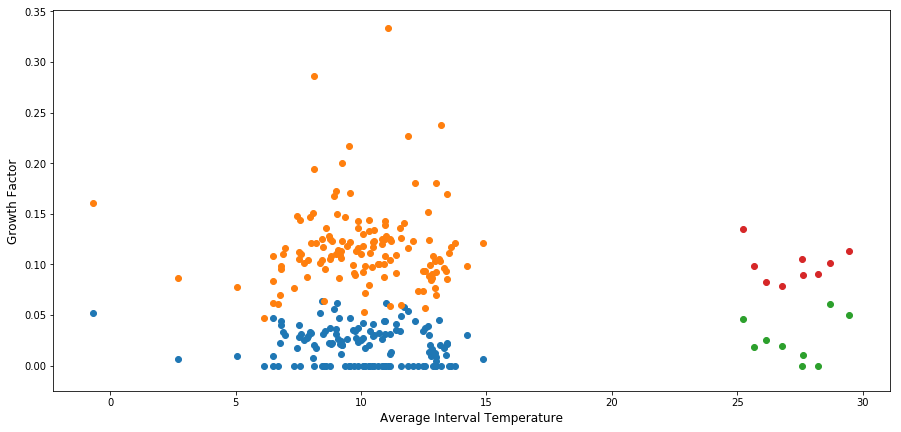

In [20]:
colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
# print(colds.head())
colds = colds[colds['GDP'] > gdp_th]
colds = colds[colds['Urbanization'] > urban_th]


hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['GDP'] >= gdp_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['Urbanization'] >= urban_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]


colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q1'])
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q3'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q1'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITH OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')
# axes.text(7,  1.5556, 'Nebraska', fontsize='large')
# axes.text(9,  1.8571, 'Iowa', fontsize='large')
# plt.text(2,4,'This text starts at point (2,4)')

# without outliers
colds_no_outliers = remove_outlier(colds,range_, [col])
hots_no_outliers = remove_outlier(hots,range_, [col])

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q1'])
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q3'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q1'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITHOUT OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')

In [25]:
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_confirmed, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITH OUTLIERS
--------------------------------------------------


TypeError: calc_wrs_ttest() missing 1 required positional argument: 'temp_range'

In [20]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     7550.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =     179.0
dtype: float64
p-value for this result is: 0.03549077520164401
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	1.8055954724619272
p-value:	0.035490775201643975
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic:	1.793167043226482
p-value:	0.03770182014580103
------------------------------------------------